# Overview #

## Project Info ##

- Developed by: Sean Pritchard
- for: CSCA 5642: Introduction to Deep Learning
- URL: https://github.com/seanpritchard94/cancer-detection
- Data Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview (Cukierski, 2018)
- Python version: 3.13

## Data Collection and Provenance ##

The data is a subset of the PatchCamelyon (PCam) dataset.

> The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU. (Veeling, 2018)

The subset of data was curated and provided as a kaggel competition. (Cukierski, 2018) We will use the Kaggle Subset of data.

A few important notes about the Kaggle subset include:

> A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. (Cukierski, 2018)

> The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark. (Cukierski, 2018)

## Deep Learning Problem Description ##

**Type of Learning and Task:** This is a **binary image classification** deep learning problem. I will build a **Convolutional Neural Network** deep learning model capable of classifying the images in the data set

**Project Goal:** Build a deep learning model capable of classifying the images with reasonable accuracy.



In [14]:
#import various libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tifffile
%matplotlib inline

# Exploratory Data Analysis, Visualization, and Cleaning #

## Data Loading ##
We will start by loading the labels and then load each image according to the order of the labels. This will keep the images and labels in sync



In [11]:
train_labels_df = pd.read_csv('data/train_labels.csv')
train_labels_df.head(10)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [12]:
y = train_labels_df["label"].values
print(y[:10])

[0 1 0 0 0 0 1 1 0 0]


In [15]:
#load the images in the order of the labels
X = []
for file_id in train_labels_df["id"]:
    file_name = f'data/train/{file_id}.tif'
    img = tifffile.imread(file_name)
    X.append(img)

print(f'len(X): {len(X)}, len(y): {len(y)}')

len(X): 220025, len(y): 220025



## EDA and Visualization ##


In [17]:
layers = {}
#We need to understand the format of these images. How many layers?
for img_array in X:
    my_layers = img_array.ndim
    if layers.get(my_layers) is None:
        layers[my_layers] = 1
    else:
        layers[my_layers] += 1

print(layers)

{3: 220025}


In [28]:
def show_image(img_array, id, label):
    plt.imshow(img_array)
    plt.title(f"Image: {id} - Label: {label}")
    plt.axis('off') # Hide axes for cleaner display
    plt.show()

def show_images(label, count):
    shown = 0
    for i in range(len(y)):
        if y[i] == label:
            shown += 1
            show_image(X[i], train_labels_df.loc[i, 'id'], y[i])
        if shown == count:
            break


We will display the first three positive label images

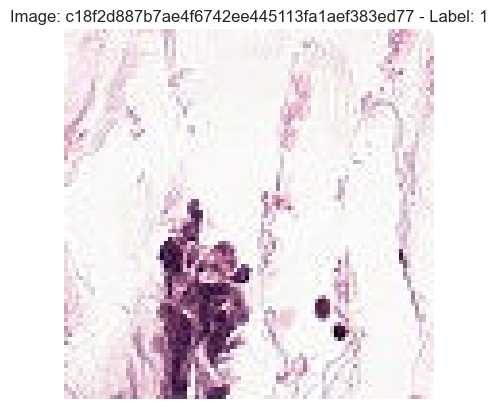

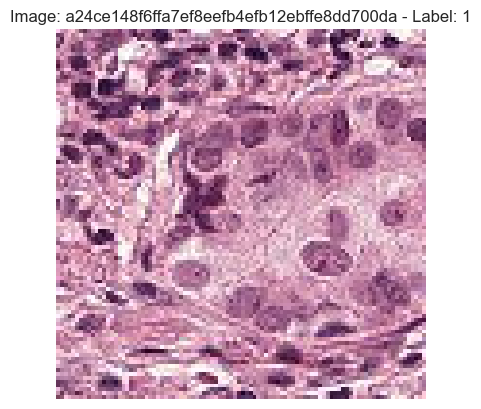

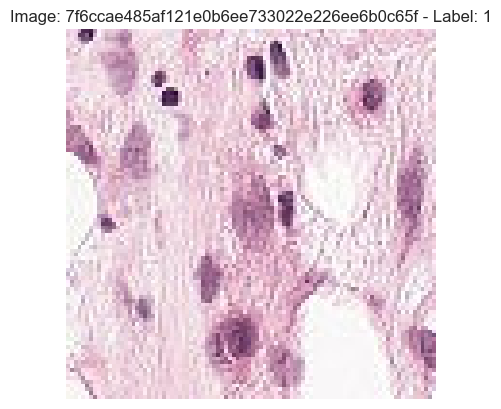

In [29]:
show_images(1, 3)

And the first three negative label images

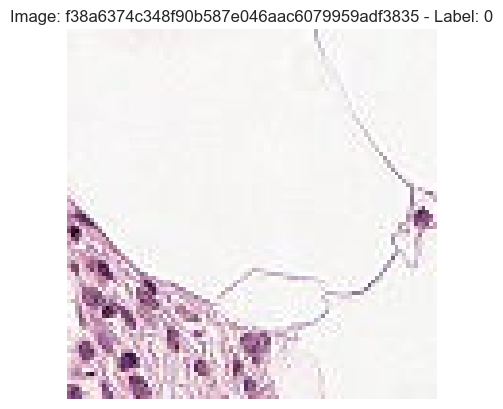

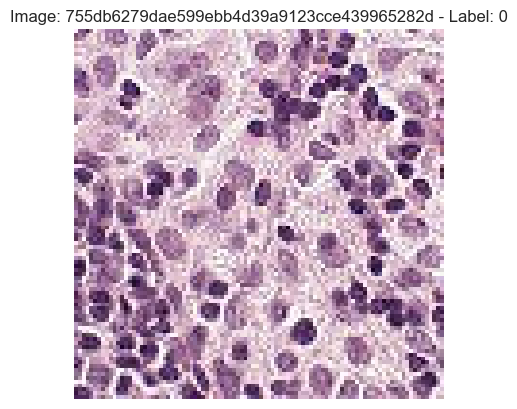

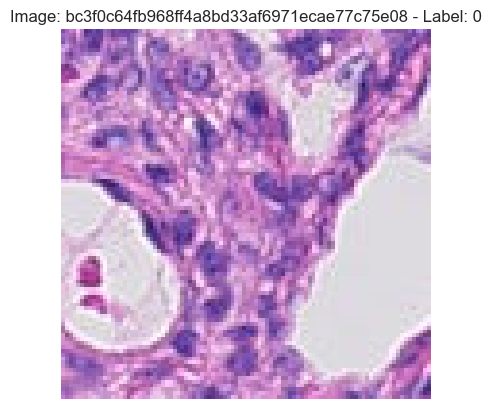

In [30]:
show_images(0, 3)

### Distribution of Average Values for RGB ###
Let's examine the distribution of average values in the three layers (R,G,B)


# Analysis (Model Building and Training) #


# Results and Analysis #

# Discussion and Conclusion #

## Learnings and Takeaways ##



## Things That Did Not Work as Expected ##



## Future Improvements ##



# Citations #

- Cukierski, W. (2018). Histopathologic Cancer detection. Kaggle. https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
- Veeling, B. (2018). Basveeling/PCAM: The Patchcamelyon (PCAM) deep learning classification benchmark. GitHub. https://github.com/basveeling/pcam


